# Download and explore CMIP6 CESM data 

Authors: Vivian Trenh, Björn Lütjens <br>
Sourced and edited from: [Pangeo](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/basic_search_and_load.html)

This notebooks shows how to query and download the Pangeo CMIP6 public data archive on Google Cloud using Python.


In [2]:
from matplotlib import pyplot as plt, animation
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import zarr
import fsspec

%matplotlib notebook
#%matplotlib widget
%config InlineBackend.figure_format = 'retina' 
plt.rcParams['figure.figsize'] = 12, 6

# Open the LARGE CMIP6 data catalogue and select relevant entries 

The data catatalog is stored as a CSV file. Here we read it with Pandas. The complete CMIP6 archive on [ESGF](https://esgf-node.llnl.gov/search/cmip6/) is 20PB of which 100TB are on GCloud -- so here we're just loading a spreadsheet that indexes the data. 

The columns of the dataframe correspond to the CMIP6 controlled vocabulary. A beginners' guide to column names is available in [this document](https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q). The variables are explained in [this document](https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271).

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
print(f'Number of available models: {np.unique(df["source_id"]).shape[0]}')
df.head()

Number of available models: 88


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


### Choose model

First, we will select one climate model from the roughly 100 available models. Specifically, we will select the **NCAR-CESM2 model**, as it is one of the most widely used climate models, offers 1° spatial and monthly resolution

In [4]:
# NCAR: National Center for Atmospheric Research
# CESM: Community Earth System Model
df_cesm = df.query('institution_id == "NCAR"'\
                    '& source_id == "CESM2"')
# df_cesm.head()

### Choose scenarios

To get started, we will choose the some scenarios that focus on emission pathways--the same as in ClimateBench by Watson-Parris et al.

In [5]:
df_cesm_em = df_cesm.query('(experiment_id == "ssp126") '\
                           ' | (experiment_id == "ssp245")'\
                           ' | (experiment_id == "ssp370")'\
                           ' | (experiment_id == "ssp585")'\
                           ' | (experiment_id == "historical")'\
                           ' | (experiment_id == "abrupt4xCO2")'\
                           ' | (experiment_id == "1pctCO2")'\
                           ' | (experiment_id == "piControl")'\
                           ' | (experiment_id == "hist-GHG")'\
                           ' | (experiment_id == "hist-aer")')
# I think, each experiment is uniquely assigned to an activity so we don't need to select for that
# df_cesm_mip = df_cesm.query('(activity_id == "DAMIP")'\
#                            ' | (activity_id == "ScenarioMIP")'\
#                            ' | (activity_id == "CMIP")')

In [7]:
from IPython.display import Markdown as md

md(f'This GCloud repository contains **{np.unique(df_cesm["experiment_id"]).shape[0]} scenarios**, also called experiments, '\
    'of the CESM2 model. If you are particularly interested in another experiment you can look on '\
    '[ESGF](https://esgf-node.llnl.gov/search/cmip6/) if it is available; for CESM2 ESGF contains 95 experiments. '\
    'The experiments are potentially highly correlated and contain missing values, but '\
    'the number of experiments provides an **upper bound on the number of data points** we have. '\
    'The experiment_id´s are explained [here](https://docs.google.com/spreadsheets/d/1SktYsKYhRxQFjUsGYbKxu6G4egpQePbQ1Y5bgERRg3M/edit#gid=1894225558). '\
    'The GCloud CESM2 data has the following experiments:<br><br>'\
    f'Experiments: <br>'+', '.join(np.unique(df_cesm['experiment_id'])))

This GCloud repository contains **46 scenarios**, also called experiments, of the CESM2 model. If you are particularly interested in another experiment you can look on [ESGF](https://esgf-node.llnl.gov/search/cmip6/) if it is available; for CESM2 ESGF contains 95 experiments. The experiments are potentially highly correlated and contain missing values, but the number of experiments provides an **upper bound on the number of data points** we have. The experiment_id´s are explained [here](https://docs.google.com/spreadsheets/d/1SktYsKYhRxQFjUsGYbKxu6G4egpQePbQ1Y5bgERRg3M/edit#gid=1894225558). The GCloud CESM2 data has the following experiments:<br><br>Experiments: <br>1pctCO2, 1pctCO2-4xext, 1pctCO2-bgc, 1pctCO2-cdr, 1pctCO2-rad, 1pctCO2to4x-withism, abrupt-0p5xCO2, abrupt-2xCO2, abrupt-4xCO2, amip, amip-4xCO2, amip-future4K, amip-hist, amip-m4K, amip-p4K, aqua-4xCO2, aqua-control, aqua-p4K, deforest-globe, esm-hist, esm-piControl, futSST-pdSIC, hist-GHG, hist-aer, hist-nat, hist-noLu, historical, land-hist, land-noLu, lig127k, omip1, pdSST-futAntSIC, pdSST-futArcSIC, pdSST-pdSIC, pdSST-piAntSIC, pdSST-piArcSIC, piClim-4xCO2, piClim-aer, piClim-control, piControl, piSST-pdSIC, piSST-piSIC, ssp126, ssp245, ssp370, ssp585

The experiments have been run for various activities, also called model intercomparison projects (MIP). For example, CMIP, ScenarioMIP or DAMIP. I think, each experiment is uniquely assigned to one activity. 

### Choose variables

For demonstration, we will **choose monthly (Amon) carbon-dioxide (co2) and near surface air temperature (tas)**. Other greenhouse cases (ghg), such as methane (ch4) and sulfur dioxide (so2) are in the CESM dataset, but only for select scenarios. More data exploration needs to be done to find the largest set of overlapping scenarios and variables.

In [6]:
df_ghg_cesm_em = df_cesm_em.query("((variable_id == 'co2') & (table_id == 'Amon'))"\
                           "| (variable_id == 'tas') & (table_id == 'Amon')")

print(f'There are {np.unique(df_cesm["variable_id"]).shape[0]} variables in the CMIP CESM data.')
df_ghg_cesm_em.sort_values('experiment_id').head()

There are 331 variables in the CMIP CESM data.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
377165,CMIP,NCAR,CESM2,1pctCO2,r1i1p1f1,Amon,co2,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/1pctCO2/r1i1p...,NaN,20191105
78810,CMIP,NCAR,CESM2,1pctCO2,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/1pctCO2/r1i1p...,NaN,20190425
377438,DAMIP,NCAR,CESM2,hist-GHG,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/DAMIP/NCAR/CESM2/hist-GHG/r3i...,NaN,20191106
377388,DAMIP,NCAR,CESM2,hist-GHG,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/DAMIP/NCAR/CESM2/hist-GHG/r2i...,NaN,20191106
377183,DAMIP,NCAR,CESM2,hist-GHG,r2i1p1f1,Amon,co2,gn,gs://cmip6/CMIP6/DAMIP/NCAR/CESM2/hist-GHG/r2i...,NaN,20191105


In [7]:
# Emissions that are in ClimateBench and CMIP6 CESM:
## co2: Mole Fraction of CO2 [mol mol-1]
## ch4global: Global Mean Mole Fraction of CH4 [1e-09]
## so2: SO2 Volume Mixing Ratio [mol mol-1]
# ------
# Other emission data that is in CMIP6 CESM but not in ClimateBench
## n2oglobal: Global Mean Mole Fraction of N2O [1e-09]
## cfc11global: Global Mean Mole Fraction of CFC11 [1e-12]
## cfc12global: Global Mean Mole Fraction of CFC12 [1e-12]
## o3: Mole Fraction of O3 [mol mol-1]
## rsds: Surface Downwelling Shortwave Radiation [W m-2]
# Other emission data that is in ClimateBench but not in CMIP6 CESM
## black carbon

### Choose realization

Next we will select a member or realization within the ensemble. I am not sure what 'realizations' refers to but it is a choice we have.

In [8]:
# Pick first member for every unique entry
print(f'There are {np.unique(df_ghg_cesm_em["member_id"]).shape[0]} different ensemble members')
df_ghg_cesm_em_sorted = df_ghg_cesm_em.sort_values(by=['experiment_id', 'variable_id', 'member_id'])
df_ghg_cesm_em_sample = df_ghg_cesm_em_sorted.drop_duplicates(
  subset = ['experiment_id', 'variable_id'],
  keep = 'first').reset_index(drop = True)
# df_ghg_cesm_em_sample

There are 11 different ensemble members


### Choose only complete entries

Lastly, we sort out incomplete entries. In this case, we only **keep entries that contain co2 AND temperature data**. This step will naively reject a lot of data, because for example aerosols are not stored in a scenario that tests for co2 sensitivity (e.g., abrupt-4xco2). ClimateBench has used data from other scenarios to fill some data gaps. 

In [9]:
df_ghg_cesm_em_unique_exp = df_ghg_cesm_em_sample.groupby('experiment_id').agg(tuple)['variable_id']
complete_experiments = [key for key, value in df_ghg_cesm_em_unique_exp.items() if ('co2' in value and 'tas' in value)]
df_ghg_cesm_em_complete = df_ghg_cesm_em_sample[df_ghg_cesm_em_sample['experiment_id'].isin(complete_experiments)]

print(f'We are left with {len(complete_experiments)} experiments '\
      'that contain complete entries. They are:\n\n', ', '.join(complete_experiments))

We are left with 6 experiments that contain complete entries. They are:

 1pctCO2, hist-GHG, historical, piControl, ssp245, ssp585


### Visualize the final data selection

In [10]:
df_ghg_cesm_em_complete

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,1pctCO2,r1i1p1f1,Amon,co2,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/1pctCO2/r1i1p...,NaN,20191105
1,CMIP,NCAR,CESM2,1pctCO2,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/1pctCO2/r1i1p...,NaN,20190425
2,DAMIP,NCAR,CESM2,hist-GHG,r1i1p1f1,Amon,co2,gn,gs://cmip6/CMIP6/DAMIP/NCAR/CESM2/hist-GHG/r1i...,NaN,20191105
3,DAMIP,NCAR,CESM2,hist-GHG,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/DAMIP/NCAR/CESM2/hist-GHG/r1i...,NaN,20190730
5,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,co2,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20191105
6,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1...,NaN,20190313
7,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,co2,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,NaN,20200124
8,CMIP,NCAR,CESM2,piControl,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i...,NaN,20190320
10,ScenarioMIP,NCAR,CESM2,ssp245,r1i1p1f1,Amon,co2,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp245...,NaN,20190730
11,ScenarioMIP,NCAR,CESM2,ssp245,r10i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp245...,NaN,20200528


# Open, visualize, and store data

### Open the dataset 

Creates data memory maps that can be loaded lazily. Uses single store using fsspec, zarr, and xarray.

In [11]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    # Get the Google Cloud path to sub-selected dataset
    zstore = df.zstore.values[0] # e.g., gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Amon/tas/gn/v20190514/
    # Create a mutable-mapping-style interface to the store
    mapper = fsspec.get_mapper(zstore)
    # Open it using xarray and zarr
    ds = xr.open_zarr(mapper, consolidated=True)
    return drop_all_bounds(ds)

# ds = open_dset(df_ta_cesm)

### Visualize and print some data statistics

#### Current surface air temperature

<IPython.core.display.Javascript object>


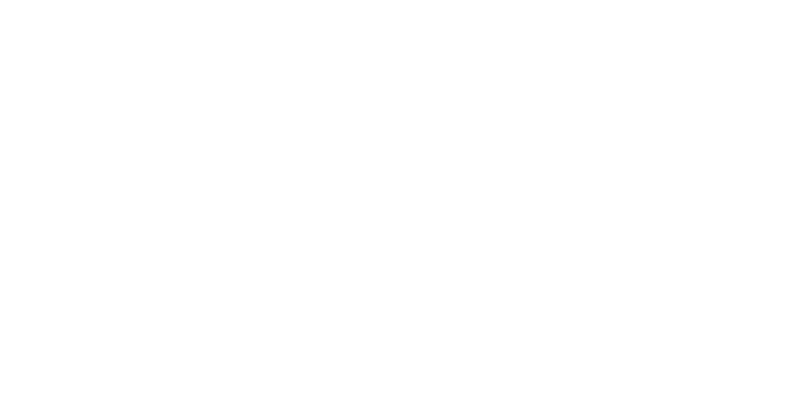

In [12]:
# Select monthly surface air temperature from the historical experiment.
df_tas_cesm = df_ghg_cesm_em_complete.query("variable_id == 'tas' & "\
                 "experiment_id == 'historical'")
ds = open_dset(df_tas_cesm)
ds.tas.sel(time='2014-01').squeeze().plot(figsize=(6,3))

#### Current CO2 concentraion at a given altitude

<IPython.core.display.Javascript object>


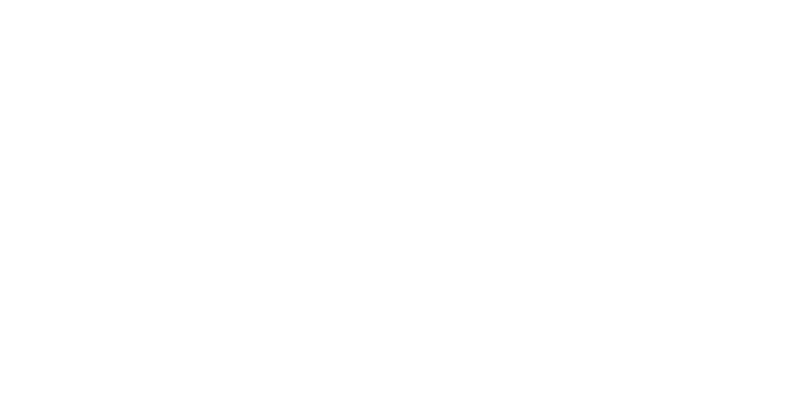

In [13]:
# This may take a while.
altitude = 100 # in Pa
df_co2_cesm = df_ghg_cesm_em_complete.query("variable_id == 'co2' & "\
                 "experiment_id == 'historical'")
ds_co2 = open_dset(df_co2_cesm)
ds_co2.co2.sel(time='2014-01', plev=altitude).plot(figsize=(6,3))

#### Some data statistics 

In [14]:
print(f'Time: The data spans {np.unique(ds["time.year"]).shape[0]} years from '\
      f'{ds["time.year"].min().values} to {ds["time.year"].max().values} with '\
      f'{np.unique(ds["time.month"]).shape[0]} months per year')
print(f'Space: Grid at {ds.nominal_resolution} resolution with ({ds.lat.shape[0]}, {ds.lon.shape[0]}) lat,lon cells.'\
      f'Co2 has {ds_co2.plev.shape[0]} vertical levels.')
print(f'One variable, e.g., {ds.tas.long_name}, occupies {ds.tas.nbytes / 1024. / 1024.}MB as {ds.tas.dtype}')
ds
# df_ta_cesm.head()

Time: The data spans 165 years from 1850 to 2014 with 12 months per year
Space: Grid at 100 km resolution with (192, 288) lat,lon cells.Co2 has 19 vertical levels.
One variable, e.g., Near-Surface Air Temperature, occupies 417.65625MB as float32


<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 1980)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
Data variables:
    tas      (time, lat, lon) float32 ...
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  306600.0
    case_id:                24
    ...                     ...
    variable_id:            tas
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r10i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/e47b79db-3925-45a7-9c0a-6799c2f1e8ae...
    version_id:             v20190313

### Store data

For demonstration, we only store surface air temperature.

In [15]:
ds.tas.to_netcdf("../data/surface_temp.nc")
# Store as numpy files
# latitude = ds.tas.lat
# longitude = ds.tas.lon
# time = ds.tas.time
# np.save("../data/surface_temp.npy", ds.tas.as_numpy() # (time,lat, lon))
# np.save("../data/time.npy", time.as_numpy())
# ...

# Plot time-series data

#### Load data

In [16]:
from matplotlib import pyplot as plt, animation
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
tas = xr.open_dataset("../data/surface_temp.nc")

#### Initialize plotting and animation code

(<Figure size 432x288 with 2 Axes>,
 <GeoAxesSubplot:title={'left':'Near-Surface Air Temp. Anomaly (in °C) in 1850.'}>,
 <matplotlib.image.AxesImage at 0x7f3c1ecbc160>)

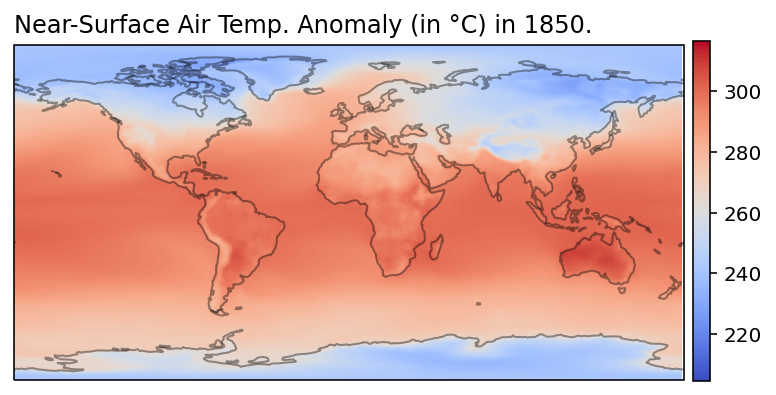

In [17]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
tas.coords['lon'] = (tas.coords['lon'] + 180) % 360 - 180
tas = tas.sortby(tas.lon)

def get_title_tas(idx, data):
    """ Returns the title for the surface temp. plot at idx
    """
    title = f"Near-Surface Air Temp. Anomaly (in °C) in "\
             f"{data.time[idx].dt.year.values}."
     #f"{months[time[idx].dt.month.values-1]}. "\
     #f"{months[data.time[idx].dt.month.values-1]}.",
    return title 

def init_plt(data, idx=0):
    """ Initializes figures and plots one frame.
    """
    # TODO: find out how img should be plotted, as max(lon)==357.5 and not 360
    img_extent = (np.min(data.lon), np.max(data.lon), np.min(data.lat),np.max(data.lat))

    fig = plt.figure()
    crs = ccrs.PlateCarree()
    ax = plt.subplot(1,1,1,projection=crs)
    im = ax.imshow(data.values[idx], origin='lower', 
                   vmin=np.min(data.values), vmax=np.max(data.values),
                   cmap='coolwarm', 
                   extent=img_extent,
                   transform=crs, animated=True) # Init first frame
    im.set_data(data.values[idx,...])
    
    ax.coastlines(alpha=0.4)
    ax.set_global()

    ax.set_title(label=get_title_tas(idx,data), loc='left')

    # Place colorbar
    divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    cax = fig.add_axes([0.91, 0.210, 0.02, 0.59])
    fig.colorbar(im, cax=cax, orientation='vertical')
    return fig, ax, im

init_plt(tas['tas'])
# print('The plot title is false. Do not trust this frame.')
# plt.show()

# Todo: figure out a way to plot with pcolormesh. Current version of pcolormesh 
# requires clipping tas.tas, which skews the plotted values.
#im = ax.pcolormesh(tas.lon, tas.lat, tas.tas[idx,:-1,:-1], transform=crs)
#im.set_array(tas.tas[idx,1:,1:])

In [18]:
def annual_mean_from_months(ds, var):
    """
    Calculate annual mean while weighting by days in each month
    Source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

annual_mean = annual_mean_from_months(tas, 'tas')

#### Create video of temperatures 

Queueing 165 frames in animation.


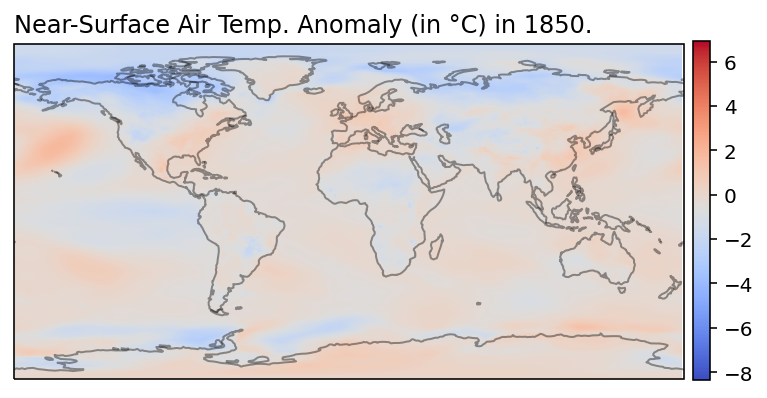

In [19]:
import sys
from tqdm import trange
from tqdm.notebook import tqdm
from IPython.display import display
from IPython.display import HTML

def init_animation(data):
    """ Initializes animation
    """
    global fig, ax, im
    fig, ax, im = init_plt(data)
    im.set_data(np.zeros(data.values[0].shape))
    return

def animate(idx,data):
    """ Adds one frame to the animation 
    """
    ax.set_title(label=get_title_tas(idx,data), loc='left')
    im.set_data(data.values[idx,...])
    #crs = ccrs.PlateCarree()
    #im = ax.pcolormesh(tas.lon, tas.lat, tas.tas[idx,:,:], transform=crs)
    #ax.coastlines(alpha=0.4)
    return im,

def create_animation(data, max_frames=None):
    """
    Creates an animation of a spatiotemporal xarray

    Args
        data xarray: Data over time, lon, lat that should be animated 
    Returns:
        anim matplotlib.animation.FuncAnimation: Animation object
    """
    interval = 1
    # Create animation
    init_animation(data)
    frames = range(data.values.shape[0]) if not max_frames else range(max_frames) # range(40)# tqdm(range(tas.shape[0]), file=sys.stdout)
    print(f'Queueing {len(frames)} frames in animation.')
    anim = animation.FuncAnimation(fig, animate, fargs=(data,),
                                   frames=frames, 
                                   interval=interval, blit=True, repeat=False)
    return anim

# Calculate annual temperature anomaly:
tas_anom = tas # todo: change ot copy 
tas_anom = annual_mean_from_months(tas_anom, 'tas')
climatology = tas_anom.mean('time')
tas_anom = tas_anom - climatology

anim = create_animation(tas_anom,max_frames=None)

### Render and save animation
This might take a while

In [20]:
%%time
anim.save('../data/animation.mp4', writer=animation.FFMpegWriter(fps=30), dpi=150)

CPU times: user 12.9 s, sys: 2.84 s, total: 15.8 s
Wall time: 17.1 s


In [21]:
from IPython.display import Video
Video("../data/animation.mp4")

# Plot annual global-mean surface air temperature

For this we need the area weighting factor for each gridpoint.

In [22]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2'")
ds_area = xr.open_zarr(fsspec.get_mapper(df_area.zstore.values[0]), consolidated=True)
print(f'Name: {ds_area.areacella.long_name}')
# ds_area

Name: Grid-Cell Area for Atmospheric Grid Variables


In [23]:
tas = xr.open_dataset("../data/surface_temp.nc")
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
ta_timeseries = (ds.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
# ta_timeseries

By default the data are loaded lazily, as Dask arrays. Here we trigger computation explicitly.

In [24]:
%%time
ta_timeseries.load()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.68 ms


<xarray.DataArray (time: 1980)>
array([284.99948, 285.23215, 285.85364, ..., 288.54376, 287.61884,
       287.06284], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

Text(0, 0.5, 'Near-Surface Air Temperature in K')

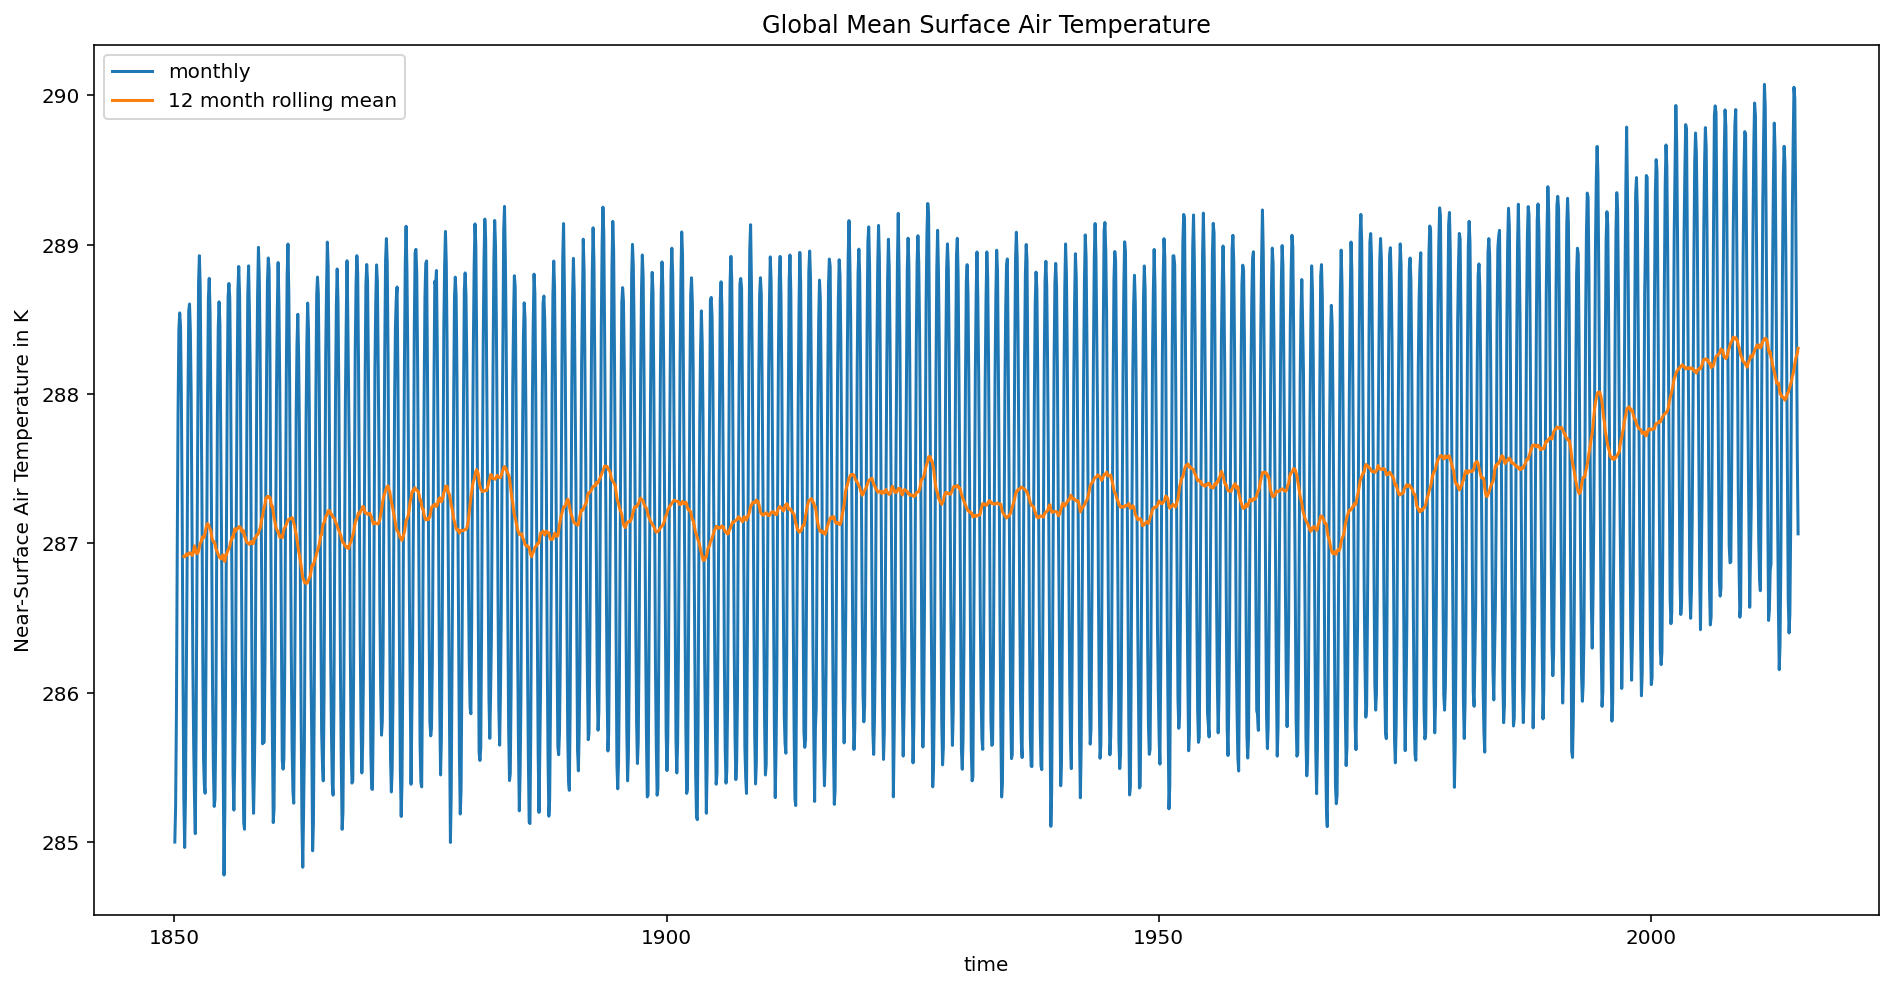

In [25]:
ta_timeseries.plot(label='monthly', figsize=(16,8))
ta_timeseries.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')
plt.ylabel(f'{ds.tas.long_name} in {ds.tas.units}')